In [1]:
import os

In [2]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\iNeuron_Projects\\End_to_End_ML_Dental_Implant_Sandblasting'

[2024-09-29 18:18:35,978: INFO: 2818965835: >>>>> Stage 04: Model Trainer Execution Started <<<<<]
[2024-09-29 18:18:35,991: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-09-29 18:18:36,014: INFO: common: yaml file: params.yaml loaded successfully]
[2024-09-29 18:18:36,017: INFO: common: created directory at: artifacts]
[2024-09-29 18:18:36,036: INFO: 2818965835: Training RandomForest model for Sa...]
[2024-09-29 18:18:36,627: INFO: 2818965835: RandomForest - MAE: 0.6683, R²: -0.2021]
[2024-09-29 18:18:36,765: INFO: 2818965835: Training BaggingRF model for Sa...]
[2024-09-29 18:18:40,339: INFO: 2818965835: BaggingRF - MAE: 0.6898, R²: -0.1897]
[2024-09-29 18:18:40,956: INFO: 2818965835: Training Ridge model for Sa...]
[2024-09-29 18:18:40,968: INFO: 2818965835: Ridge - MAE: 0.6573, R²: -0.0637]
[2024-09-29 18:18:40,978: INFO: 2818965835: Training RandomForest model for CV...]
[2024-09-29 18:18:41,365: INFO: 2818965835: RandomForest - MAE: 0.6683, R²: -0.2021]
[

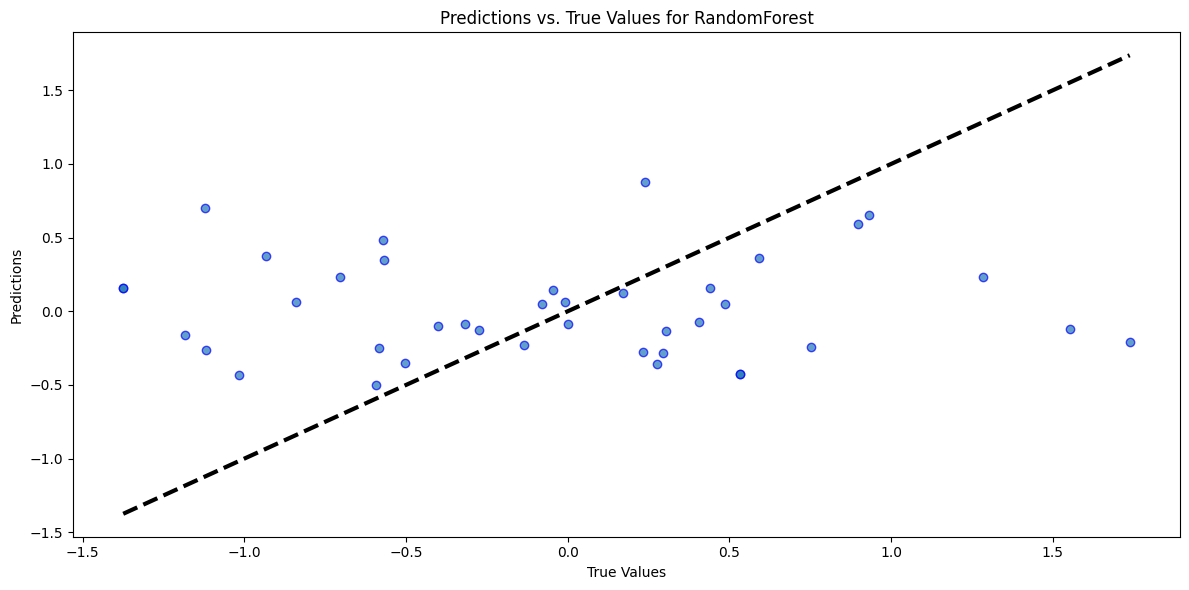

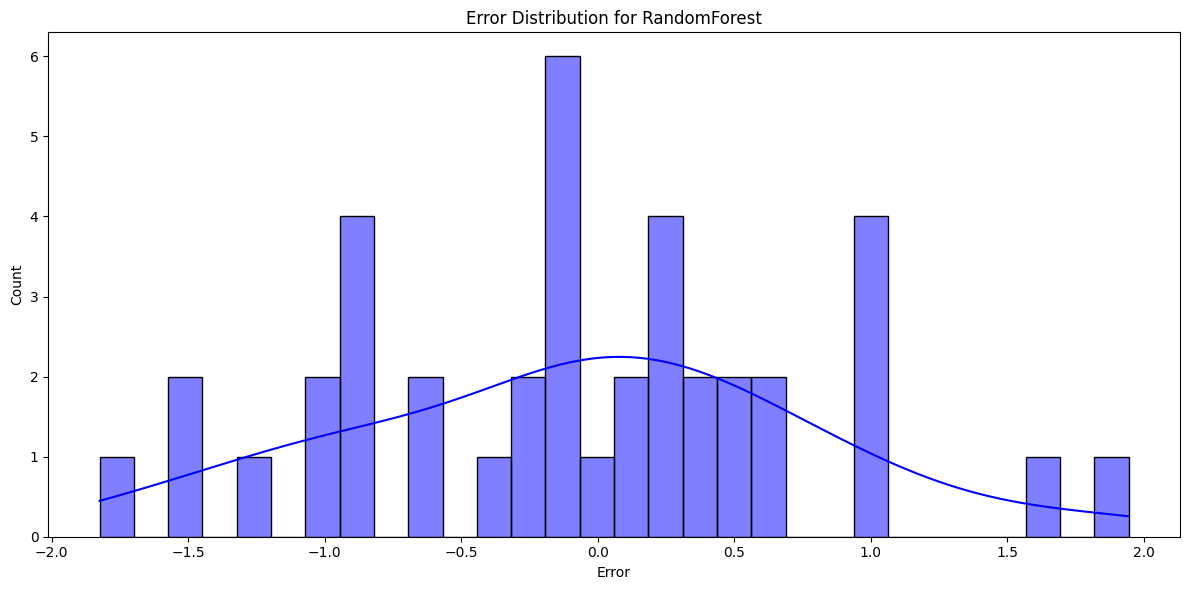

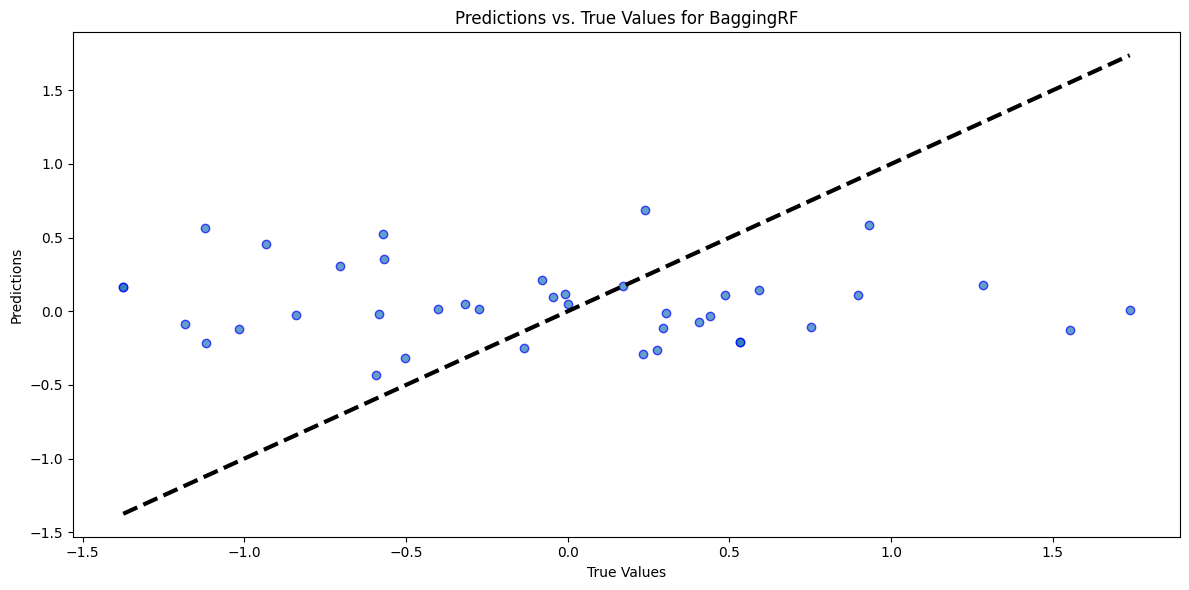

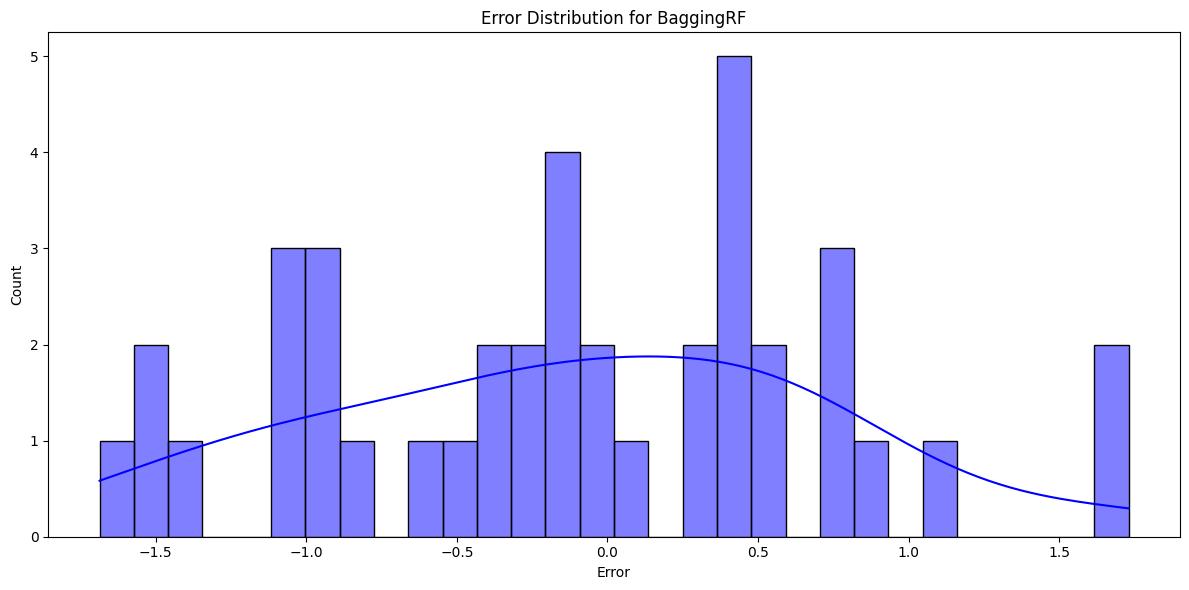

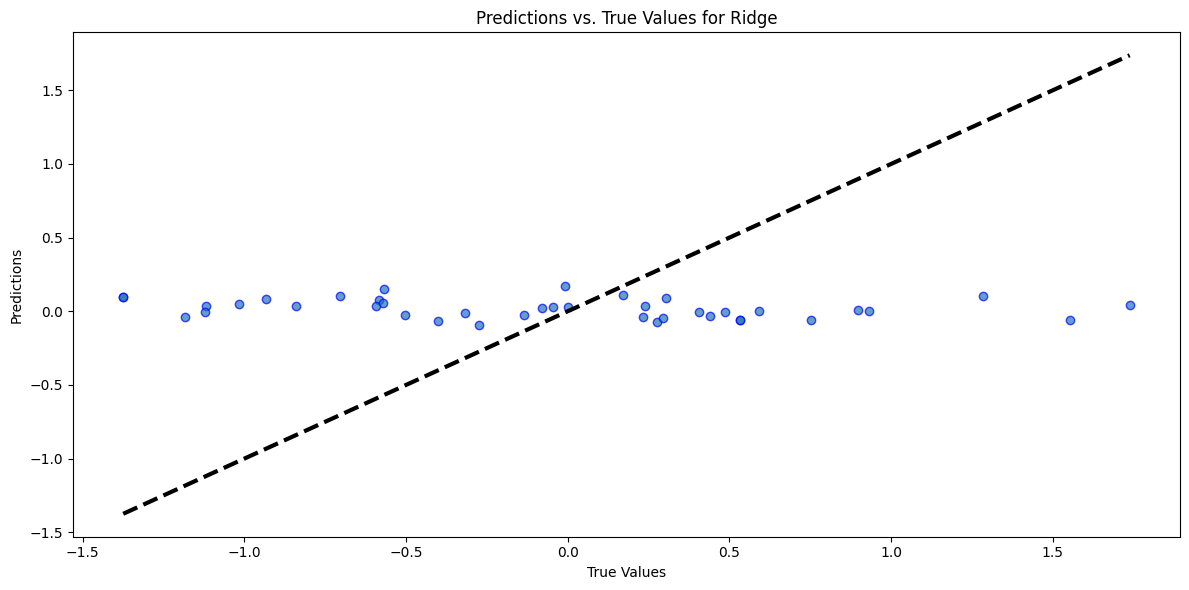

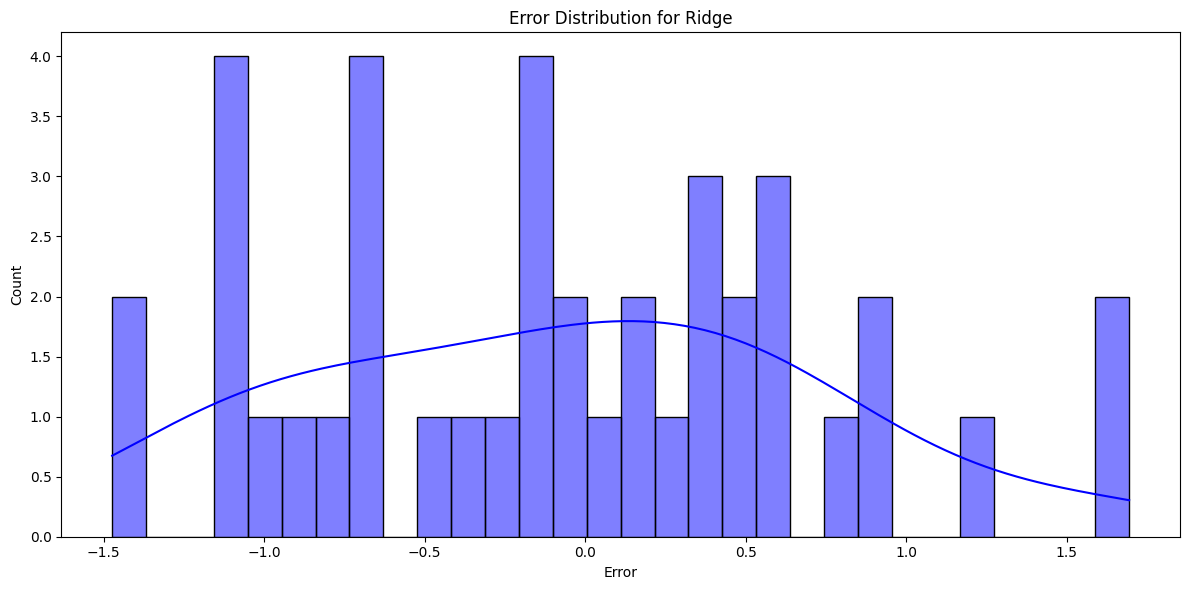

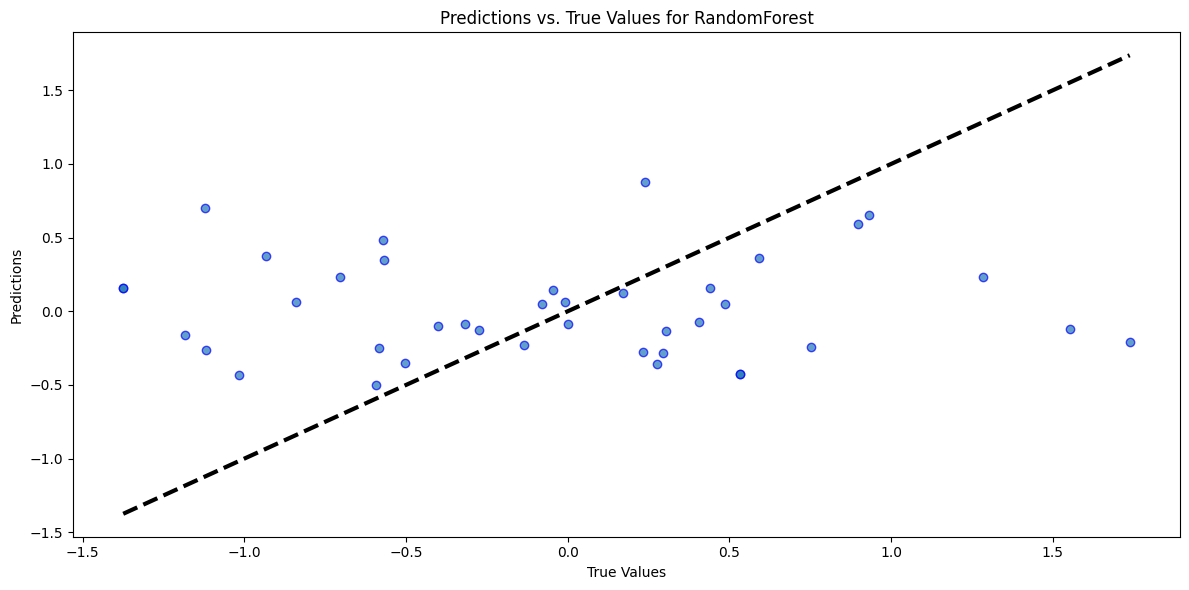

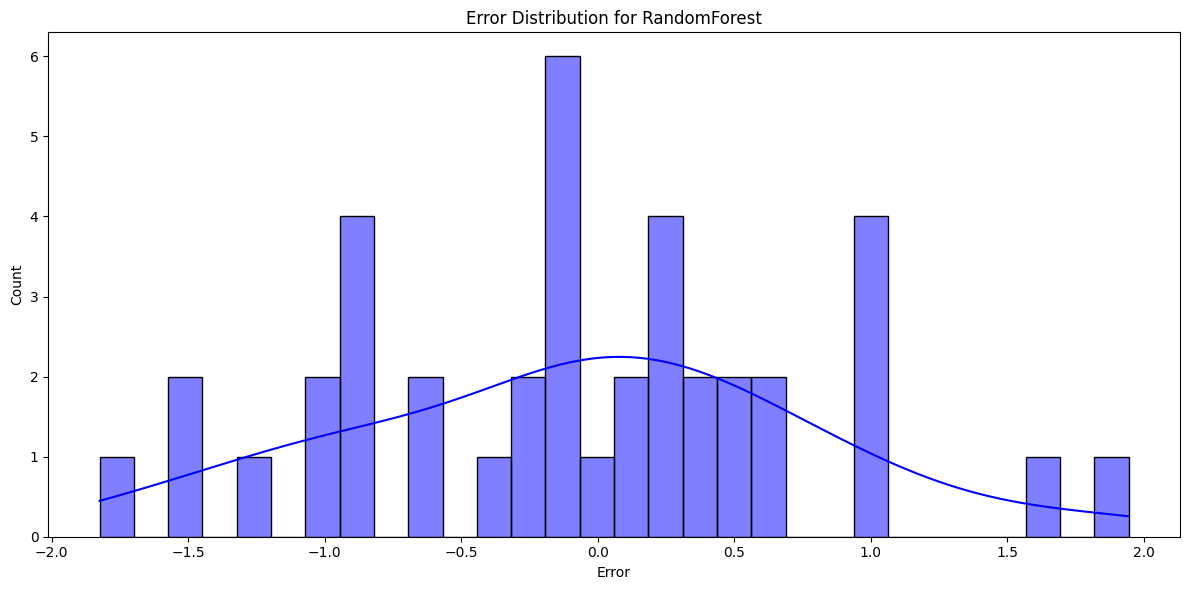

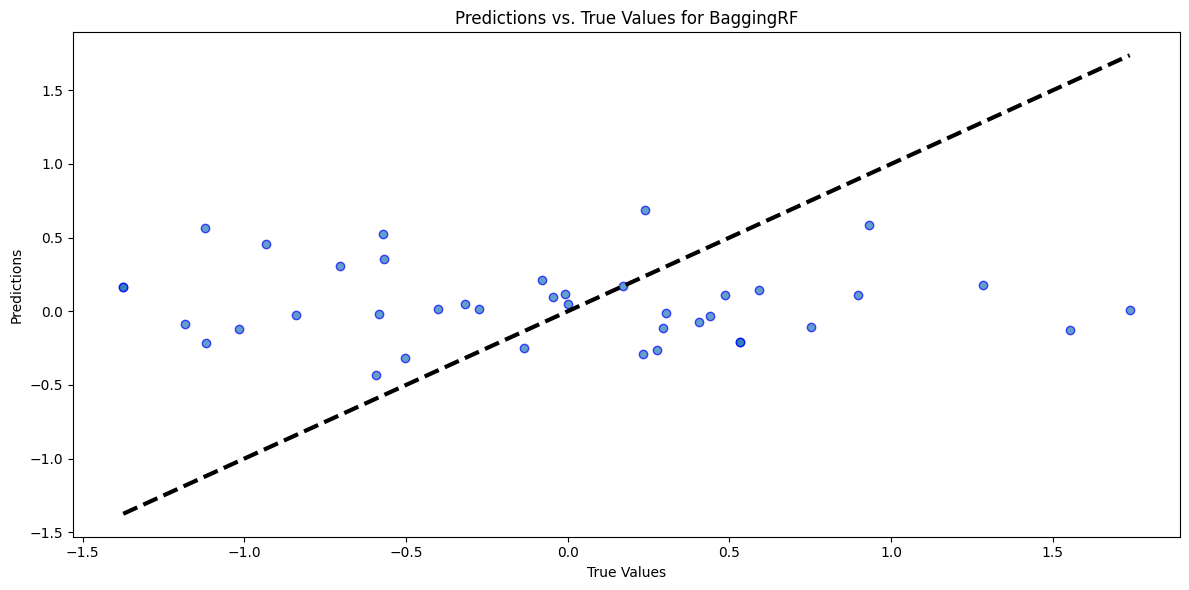

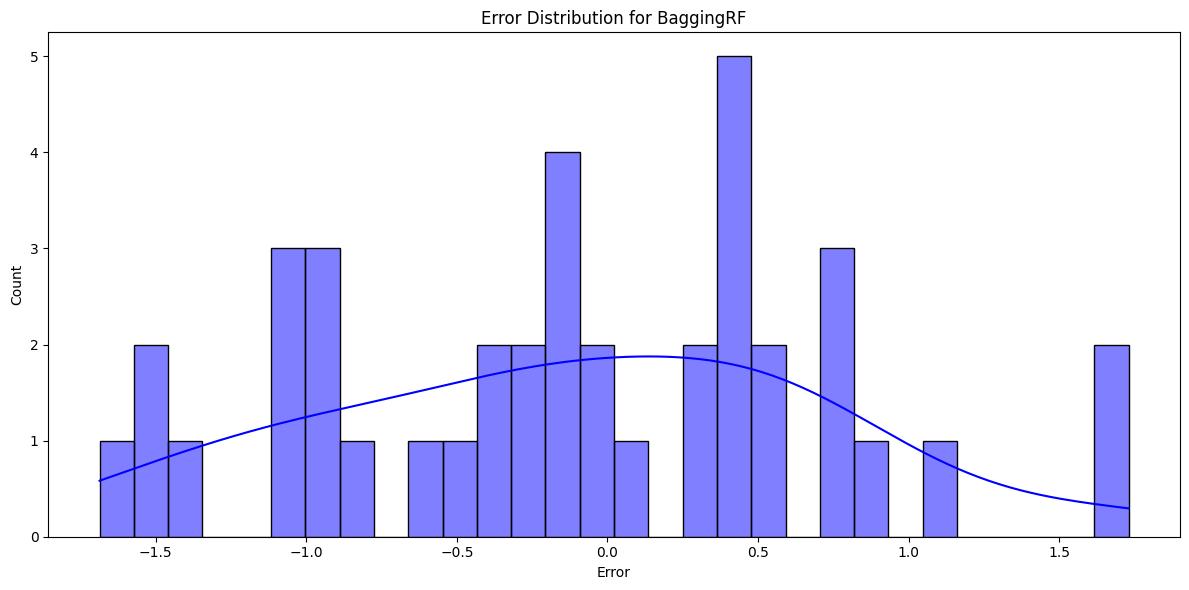

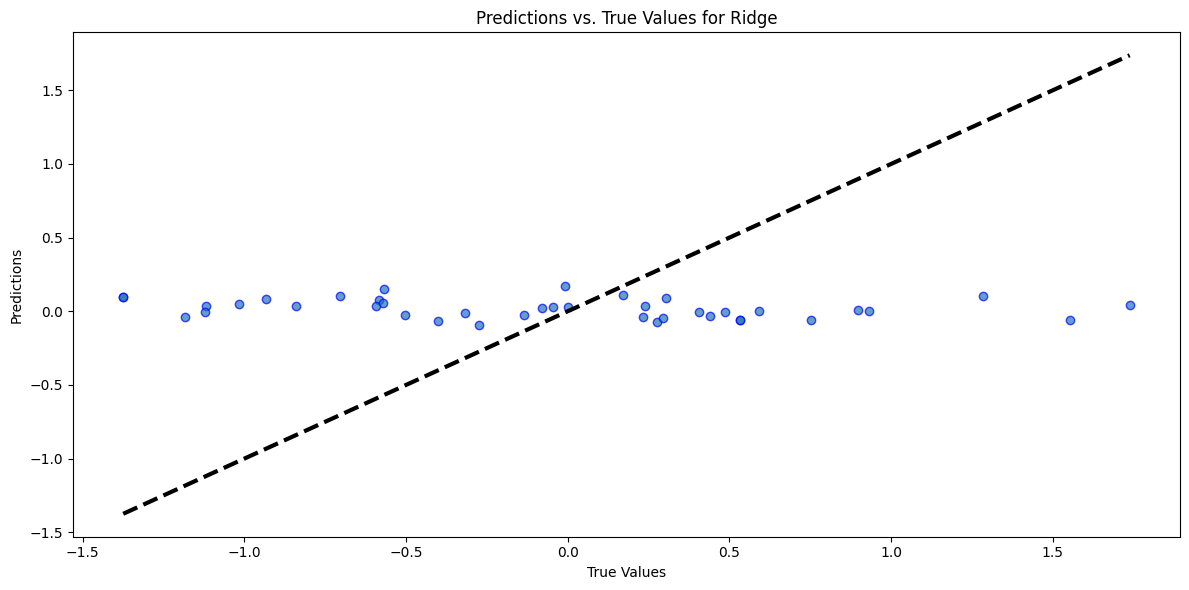

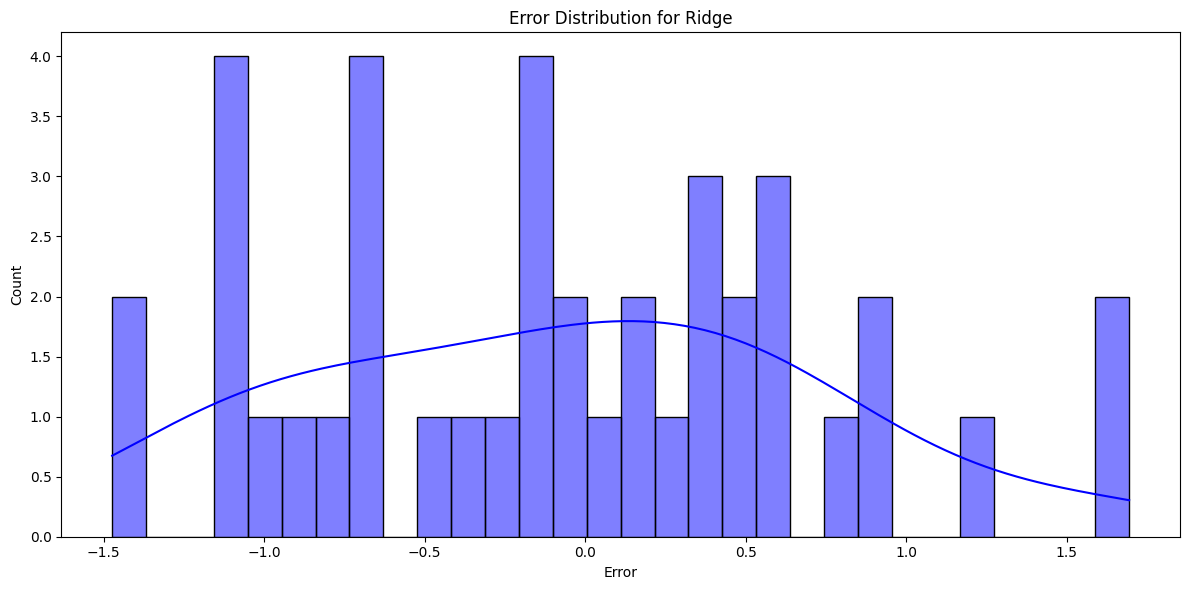

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[2024-09-29 18:19:17,105: INFO: 2818965835: Best parameters for RandomForest: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}]


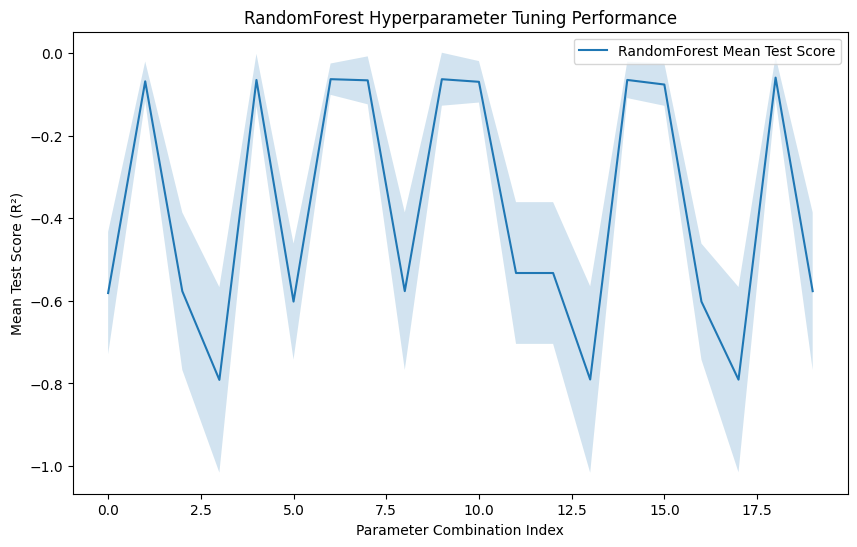

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[2024-09-29 18:25:50,065: INFO: 2818965835: Best parameters for BaggingRF: {'n_estimators': 50, 'max_samples': 0.7, 'max_features': 0.5, 'estimator__max_depth': None}]


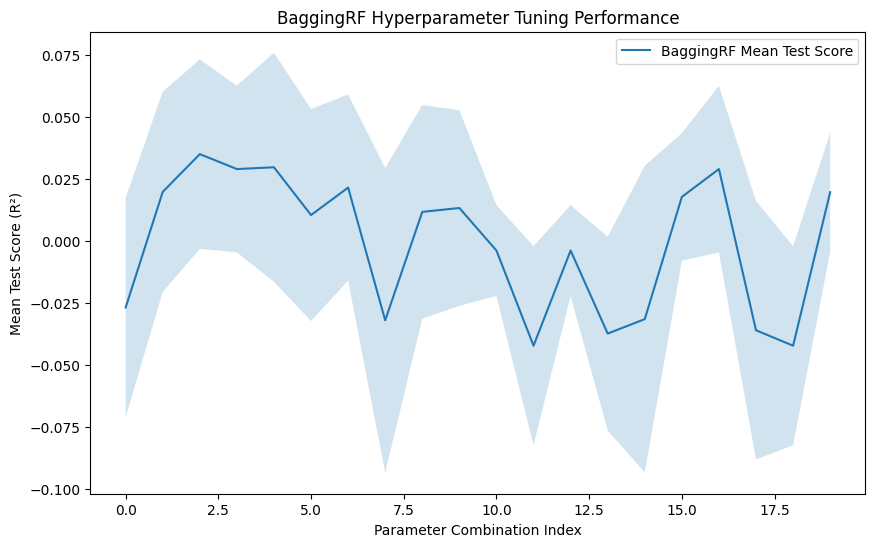

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[2024-09-29 18:25:50,548: INFO: 2818965835: Best parameters for Ridge: {'alpha': 100}]


c:\Users\Farshid Hesami\anaconda3\envs\mlProject\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


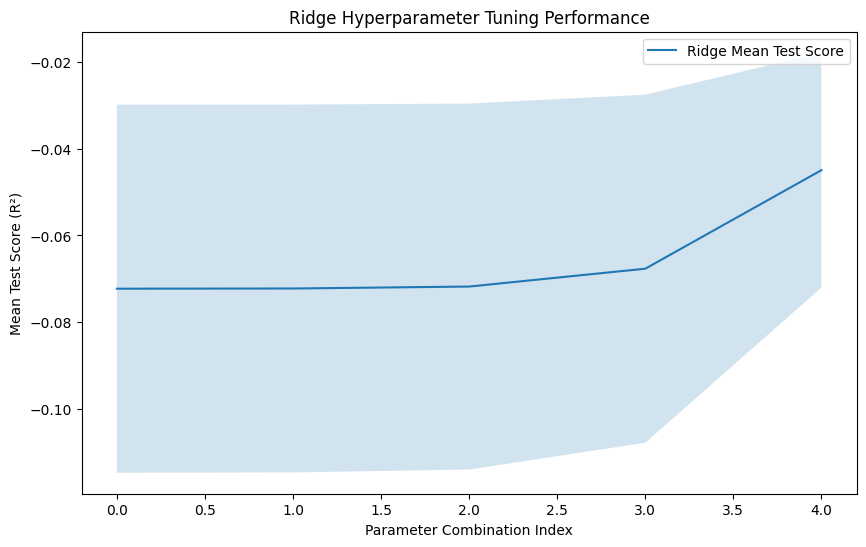

[2024-09-29 18:25:54,852: INFO: 2818965835: Model training, hyperparameter tuning, and visualizations completed successfully.]
[2024-09-29 18:25:54,863: INFO: 2818965835: >>>>> Stage 04: Model Trainer Execution Completed <<<<<]


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path
from Dental_Implant_Sandblasting import logger
from Dental_Implant_Sandblasting.utils.common import read_yaml, create_directories
from Dental_Implant_Sandblasting.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH

# Data class for Model Training configuration
from dataclasses import dataclass

@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    transformed_train_dir: Path
    transformed_test_dir: Path
    test_size: float
    random_state: int
    param_grid_rf: dict
    param_grid_bagging: dict
    param_grid_ridge: dict
    models: dict
    n_iter: int
    cv: int
    verbose: int
    n_jobs: int

# Configuration Manager class for loading configurations
class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config['artifacts_root']])

    def get_model_trainer_config(self) -> ModelTrainerConfig:
        config = self.config['model_trainer']
        params = self.params['model_training']

        model_trainer_config = ModelTrainerConfig(
            root_dir=Path(config['root_dir']),
            transformed_train_dir=Path(config['transformed_train_dir']),
            transformed_test_dir=Path(config['transformed_test_dir']),
            test_size=params['test_size'],
            random_state=params['random_state'],
            param_grid_rf=params['param_grid_rf'],
            param_grid_bagging=params['param_grid_bagging'],
            param_grid_ridge=params['param_grid_ridge'],
            models=params['models'],
            n_iter=params['n_iter'],
            cv=params['cv'],
            verbose=params['verbose'],
            n_jobs=params['n_jobs']
        )
        return model_trainer_config

# ModelTrainer class
class ModelTrainer:
    def __init__(self, config: ModelTrainerConfig):
        self.config = config

    # Custom evaluation metrics
    def smape(self, y_true, y_pred):
        return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-10))

    def mape(self, y_true, y_pred):
        return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

    def load_data(self):
        # Define paths to the training and testing data
        train_sa_path = self.config.transformed_train_dir / 'train_sa_target.csv'
        test_sa_path = self.config.transformed_test_dir / 'test_sa_target.csv'
        train_cv_path = self.config.transformed_train_dir / 'train_cv_target.csv'
        test_cv_path = self.config.transformed_test_dir / 'test_cv_target.csv'

        # Load data
        train_sa_data = pd.read_csv(train_sa_path)
        test_sa_data = pd.read_csv(test_sa_path)
        train_cv_data = pd.read_csv(train_cv_path)
        test_cv_data = pd.read_csv(test_cv_path)

        # Extracting feature columns
        X_train_sa = train_sa_data.iloc[:, :-1]  # Assuming the last column is the target
        y_train_sa = train_sa_data.iloc[:, -1]
        X_test_sa = test_sa_data.iloc[:, :-1]
        y_test_sa = test_sa_data.iloc[:, -1]

        X_train_cv = train_cv_data.iloc[:, :-1]  # Assuming the last column is the target
        y_train_cv = train_cv_data.iloc[:, -1]
        X_test_cv = test_cv_data.iloc[:, :-1]
        y_test_cv = test_cv_data.iloc[:, -1]

        return (X_train_sa, y_train_sa, X_test_sa, y_test_sa), (X_train_cv, y_train_cv, X_test_cv, y_test_cv)

    def train_models(self, X_train, y_train, X_test, y_test, model_name):
        models = {
            "RandomForest": RandomForestRegressor(random_state=self.config.random_state),
            "BaggingRF": BaggingRegressor(estimator=RandomForestRegressor(random_state=self.config.random_state), random_state=self.config.random_state),
            "Ridge": Ridge()
        }

        # Initialize dictionary for storing model performance
        model_performance = {}

        # Ensure the 'model_trainer' directory exists
        model_trainer_dir = self.config.root_dir  # Directly use root_dir from the config
        os.makedirs(model_trainer_dir, exist_ok=True)

        for name, model in models.items():
            logger.info(f"Training {name} model for {model_name}...")
            model.fit(X_train, y_train)

            # Predictions
            y_pred = model.predict(X_test)

            # Calculate evaluation metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mape_val = self.mape(y_test, y_pred)
            smape_val = self.smape(y_test, y_pred)

            model_performance[name] = {
                "MAE": mae,
                "MSE": mse,
                "R²": r2,
                "MAPE": mape_val,
                "SMAPE": smape_val
            }

            logger.info(f"{name} - MAE: {mae:.4f}, R²: {r2:.4f}")

            # Save the model
            joblib.dump(model, model_trainer_dir / f"{name}_{model_name}.joblib")

        return model_performance

    def hyperparameter_tuning(self, X_train, y_train, model_name):
        if model_name == "RandomForest":
            param_grid = self.config.param_grid_rf
            model = RandomForestRegressor(random_state=self.config.random_state)
        elif model_name == "BaggingRF":
            param_grid = self.config.param_grid_bagging
            model = BaggingRegressor(estimator=RandomForestRegressor(random_state=self.config.random_state), random_state=self.config.random_state)
        elif model_name == "Ridge":
            param_grid = self.config.param_grid_ridge
            model = Ridge()

        try:
            random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=self.config.n_iter,
                                               cv=self.config.cv, verbose=self.config.verbose, random_state=self.config.random_state, n_jobs=self.config.n_jobs)
            random_search.fit(X_train, y_train)
            best_model = random_search.best_estimator_
            logger.info(f"Best parameters for {model_name}: {random_search.best_params_}")

            # Visualizations for Hyperparameter Tuning
            self.visualize_hyperparameter_tuning(random_search, model_name)

            return best_model
        except Exception as e:
            logger.exception(f"Error during hyperparameter tuning for {model_name}: {e}")
            raise e

    # Visualization method for hyperparameter tuning
    def visualize_hyperparameter_tuning(self, random_search, model_name):
        results = random_search.cv_results_
        plt.figure(figsize=(10, 6))
        plt.plot(results['mean_test_score'], label=f'{model_name} Mean Test Score')
        plt.fill_between(
            range(len(results['mean_test_score'])),
            results['mean_test_score'] - results['std_test_score'],
            results['mean_test_score'] + results['std_test_score'],
            alpha=0.2
        )
        plt.title(f'{model_name} Hyperparameter Tuning Performance')
        plt.xlabel('Parameter Combination Index')
        plt.ylabel('Mean Test Score (R²)')
        plt.legend()
        plt.show()

    def visualize_results(self, y_test, y_pred, model_name):
        plt.figure(figsize=(12, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='b')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
        plt.title(f"Predictions vs. True Values for {model_name}")
        plt.xlabel("True Values")
        plt.ylabel("Predictions")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.histplot(y_test - y_pred, kde=True, bins=30, color='blue')
        plt.title(f"Error Distribution for {model_name}")
        plt.xlabel("Error")
        plt.tight_layout()
        plt.show()

    def execute(self):
        try:
            # Load the data
            (X_train_sa, y_train_sa, X_test_sa, y_test_sa), (X_train_cv, y_train_cv, X_test_cv, y_test_cv) = self.load_data()

            # Model training for Surface Roughness (Sa)
            sa_performance = self.train_models(X_train_sa, y_train_sa, X_test_sa, y_test_sa, "Sa")

            # Model training for Cell Viability (CV)
            cv_performance = self.train_models(X_train_cv, y_train_cv, X_test_cv, y_test_cv, "CV")

            # Visualize results for Surface Roughness (Sa)
            for model_name in sa_performance:
                y_pred_sa = joblib.load(self.config.root_dir / f"{model_name}_Sa.joblib").predict(X_test_sa)
                self.visualize_results(y_test_sa, y_pred_sa, model_name)

            # Visualize results for Cell Viability (CV)
            for model_name in cv_performance:
                y_pred_cv = joblib.load(self.config.root_dir / f"{model_name}_CV.joblib").predict(X_test_cv)
                self.visualize_results(y_test_cv, y_pred_cv, model_name)

            # Hyperparameter tuning for each model
            best_rf_model_sa = self.hyperparameter_tuning(X_train_sa, y_train_sa, "RandomForest")
            best_rf_model_cv = self.hyperparameter_tuning(X_train_cv, y_train_cv, "BaggingRF")
            best_ridge_model_sa = self.hyperparameter_tuning(X_train_sa, y_train_sa, "Ridge")

            # Save the best models after hyperparameter tuning
            joblib.dump(best_rf_model_sa, self.config.root_dir / "best_rf_model_sa.joblib")
            joblib.dump(best_rf_model_cv, self.config.root_dir / "best_rf_model_cv.joblib")
            joblib.dump(best_ridge_model_sa, self.config.root_dir / "best_ridge_model_sa.joblib")

            logger.info("Model training, hyperparameter tuning, and visualizations completed successfully.")

        except Exception as e:
            logger.exception(f"Error during model training execution: {e}")
            raise e

# Pipeline execution
try:
    logger.info(">>>>> Stage 04: Model Trainer Execution Started <<<<<")
    config_manager = ConfigurationManager()
    model_trainer_config = config_manager.get_model_trainer_config()
    model_trainer = ModelTrainer(config=model_trainer_config)
    model_trainer.execute()
    logger.info(">>>>> Stage 04: Model Trainer Execution Completed <<<<<")
except Exception as e:
    logger.exception(e)
    raise e
